# Loop over satellite datafiles, making annotated images 

Annotation code from Claude, Sep 17 2025 
https://claude.ai/public/artifacts/2b14fb0a-0ee5-4590-ae5b-a9dc841e5970

Prompt 
You got it, I want the semi-transparent annotations to spread with time, conserving ink as if an amount had been added with an eyedropper at the event locations. Perhaps make room for a fading time scale,  beyond that spatial spreading effect, in case the accumulation gets too thick, although perhaps it will not since the hypothetical circles over which the 'ink' is spread can expand beyond the image area. I want three annotation layers. Two are similar, let's call them brown and green. Each is an expanding and widening circle, perhaps smoothed a bit at its perimeter, concentric on the event location where it was launched. The brown annulus moves 52 pixels per time step, the green one moves 23 pixels per time step. The third annotation is a little more complicated: for every event, select randomly from a list of dirtycolors = ['orange','red','pink'] and speeds = [10,7,4] pixels per time step. Unlike the brown and green annotations, which fade only in an ink-conserving way, and accumulate over time, these dirty circles erase all the other dirty colors and replace them with the new dirty color.


In [1]:
import numpy as np
from collections import deque
import matplotlib.patches as patches
import cartopy.crs as ccrs

In [215]:
# class EyedropperAnnotator: updated to have size --> initial opacity

from collections import deque
import numpy as np
import matplotlib.path as mpath

class EyedropperAnnotator:
    def __init__(self):
        self.brown_events = deque()
        self.green_events = deque()
        self.dirty_events = deque()
        self.dirtycolors = ['orange', 'red', 'pink']
        self.speeds = [10, 7, 4]
        
    def add_events(self, centroids, sizes, current_time):
        """Add new events with sizes at current time"""
        for (lat, lon), size in zip(centroids, sizes):
            self.brown_events.append((lon, lat, current_time, size))
            self.green_events.append((lon, lat, current_time, size))
            
            color = random.choice(self.dirtycolors)
            speed = random.choice(self.speeds)
            self.dirty_events.clear()
            self.dirty_events.append((lon, lat, current_time, color, speed, size))
    
    def plot_one_expanding_ring(self, ax, current_time, facecolor='yellow'):
        """Plot expanding annuli with size-dependent opacity"""
        import matplotlib.patches as patches
        import cartopy.crs as ccrs
        
        for lon, lat, birth_time, size in list(self.brown_events):
            age = current_time - birth_time
            if age < 0:
                continue
                
            outer_r = age * 52 * 60 * 30 / 111111.1
            area = np.pi * (outer_r**2)
            alpha = min(0.8, size / max(area, 1))
            
            if alpha > 0.01:
                if outer_r > 0:
                    annulus = patches.Annulus((lon, lat), outer_r, width=outer_r/2, 
                                          facecolor=facecolor, alpha=alpha, 
                                          edgecolor='none', transform=ccrs.PlateCarree())
                    ax.add_patch(annulus)
            else:
                self.brown_events.remove((lon, lat, birth_time, size))

    def plot_expanding_ring_coriolis(self, ax, current_time, facecolor='orange', 
                                     spoke_color='red', n_spokes=12):
        """
        Plot expanding annuli with Coriolis-curved spokes.
        
        The spokes show counterclockwise rotation due to Coriolis force:
        - Each spoke curves from inner_r to outer_r
        - Older (larger radius) parts lag behind in azimuth
        - Mean azimuth rotates counterclockwise with age
        
        Args:
            ax: matplotlib axis
            current_time: current frame time
            facecolor: color of annulus
            spoke_color: color of Coriolis spokes
            n_spokes: number of spokes (default 12)
        """
        
        to_remove = []
        for i, (lon, lat, birth_time, size) in enumerate(list(self.brown_events)):
            age = current_time - birth_time
            if age < 0:
                continue
                
            outer_r = age * 52 * 60 * 30 / 111111.1  # degrees
            inner_r = outer_r / 2
            area = np.pi * (outer_r**2)
            alpha = min(0.8, size / max(area, 1))
            
            if alpha > 0.01:
                if outer_r > 0:
                    # Draw base annulus
                    annulus = patches.Annulus((lon, lat), outer_r, width=outer_r/2, 
                                          facecolor=facecolor, alpha=alpha, 
                                          edgecolor='none', transform=ccrs.PlateCarree())
                    ax.add_patch(annulus)
                    
                    # Draw Coriolis spokes
                    # Coriolis rotation: f = 2*Omega*sin(lat), integrated over time
                    # Approximate angular displacement: delta_theta ∝ age^2 * sin(lat)
                    lat_rad = np.radians(lat)
                    coriolis_factor = np.sin(lat_rad)  # Coriolis strength
                    
                    # Mean counterclockwise rotation increases with age
                    mean_rotation = coriolis_factor * age * 50  # degrees, tunable
                    
                    # Differential rotation: inner parts rotate more than outer
                    # (because they've experienced Coriolis longer)
                    rotation_gradient = coriolis_factor * age * 20  # degrees, tunable
                    
                    for spoke_idx in range(n_spokes):
                        # Base azimuth for this spoke
                        base_azimuth = spoke_idx * 360 / n_spokes
                        
                        # Create curved spoke from inner_r to outer_r
                        n_points = 20
                        radii = np.linspace(inner_r, outer_r, n_points)
                        
                        # Azimuth varies along spoke due to Coriolis
                        # Inner radius rotates more (older trajectory)
                        azimuths = base_azimuth + mean_rotation + rotation_gradient * (1 - radii/outer_r)
                        
                        # Convert to lon/lat offsets
                        x_offsets = radii * np.cos(np.radians(azimuths))
                        y_offsets = radii * np.sin(np.radians(azimuths))
                        
                        # Create curved path
                        spoke_lons = lon + x_offsets
                        spoke_lats = lat + y_offsets
                        
                        # Plot as curved line
                        ax.plot(spoke_lons, spoke_lats, color=spoke_color, 
                               alpha=alpha*0.6, linewidth=1.5, 
                               transform=ccrs.PlateCarree())
            else:
                to_remove.append(i)
        
        for i in reversed(to_remove):
            del self.brown_events[i]
    
    # Add this method to your EyedropperAnnotator class
    

In [216]:
# def get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230, min_size=0)

from scipy.ndimage import label, gaussian_filter
import numpy as np

def get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230, min_size=0):
    """
    Extract feature centroids in (lat, lon) and their sizes from xarray DataArray.
    
    Args:
        data_array: xarray DataArray with lat/lon coordinates
        sigma: smoothing parameter
        threshold: features where data < threshold
        min_size: minimum feature size in pixels (features smaller are excluded)
    
    Returns:
        centroids: list of (lat, lon) tuples
        sizes: list of feature sizes (pixel counts)
    """
    
    smimage = gaussian_filter(data_array.values, sigma=sigma)
    labeled_array, num_features = label(smimage < threshold)
    
    lats = data_array.lat.values
    lons = data_array.lon.values
    
    centroids, sizes = [], []
    for fid in range(1, num_features + 1):
        rows, cols = np.where(labeled_array == fid)
        size = len(rows)
        if size >= min_size:
            sizes.append(size)
            centroids.append((lats[int(rows.mean())], lons[int(cols.mean())]))
    
    return centroids, sizes


#from matplotlib.patches import Circle  # for a graphical test 
#centroids,sizes = get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230)
#data_array.plot()
#for (lat, lon), size in zip(centroids, sizes):
#    plt.gca().add_patch(Circle((lon, lat), radius=np.sqrt(size/200/np.pi), fill=False, edgecolor='red'))

In [217]:
# WATERSHED get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230, min_size=0)

from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt

def get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230, min_size=0):
    smimage = gaussian_filter(data_array.values, sigma=sigma)
    binary = smimage < threshold
    
    dist = distance_transform_edt(binary)
    labeled_array = watershed(-dist, mask=binary)
    
    lats = data_array.lat.values
    lons = data_array.lon.values
    
    centroids, sizes = [], []
    for fid in range(1, labeled_array.max() + 1):
        rows, cols = np.where(labeled_array == fid)
        size = len(rows)
        if size >= min_size:
            sizes.append(size)
            centroids.append((lats[int(rows.mean())], lons[int(cols.mean())]))
    
    return centroids, sizes

#from matplotlib.patches import Circle  # for a graphical test 
#centroids,sizes = get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230)
#data_array.plot()
#for (lat, lon), size in zip(centroids, sizes):
#    plt.gca().add_patch(Circle((lon, lat), radius=np.sqrt(size/200/np.pi), fill=False, edgecolor='red'))

In [218]:
# Open data files 

from pathlib import Path
datafiles = '/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/IRfiles/'+ \
            'merg_20170813[0,1]*_4km-pixel.nc4'

OUTPUT = Path('/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/')
OUTPUT.mkdir(exist_ok=True, parents=True) 
OUTDIR = '/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/'

Tb = xr.open_mfdataset(datafiles).Tb
Tb

<xarray.DataArray 'Tb' (time: 30, lat: 1100, lon: 1374)> Size: 181MB
dask.array<concatenate, shape=(30, 1100, 1374), dtype=float32, chunksize=(2, 1100, 1374), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 5kB 0.01819 0.05457 0.09094 ... 49.89 49.93 49.97
  * lat      (lat) float32 4kB -19.99 -19.96 -19.92 -19.88 ... 19.92 19.96 19.99
  * time     (time) datetime64[ns] 240B 2017-08-13T05:00:00.000013312 ... 201...
Attributes:
    units:          K
    standard_name:  brightness_temperature

/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot0.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot1.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot2.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot3.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot4.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot5.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot6.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot7.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot8.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot9.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_annot_spokes/annot10.png
/Users/bmapes/Box/Sky_Symphony_Box/IRMA2017_weekprior/Images_ann

KeyboardInterrupt: 

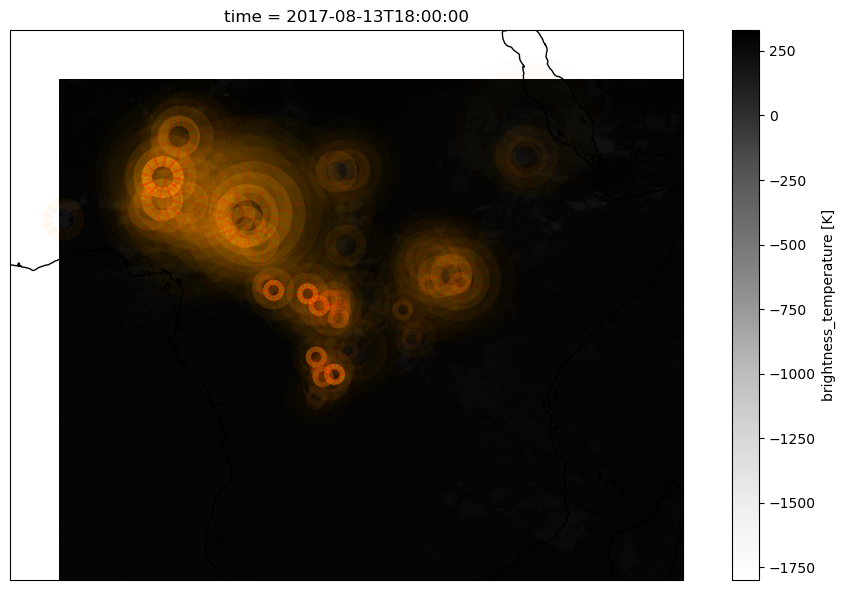

In [219]:
# loop over xarray files making .png images, WITH ANNOTATIONS

import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

vmin = 200
vmax = 330

# Initialize annotator
annotator = EyedropperAnnotator( )  # Approximate figure size in pixels

# Loop over all files in the folder
for it in range(len(Tb.time)):
    
    data_array = Tb[it].interpolate_na(dim="lon", method="linear", max_gap=2)
# Events (play with cell at bottom) 
    #centroids,sizes = get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230, \
    #                                                  min_size=0)
    centroids,sizes = get_feature_centroids_and_sizes(data_array, sigma=7, threshold=230, 
                                                      min_size=20)

    #event_locations = [(20 + it, 0)]  # lon, lat in degrees specified in testing
    #if(it > 4): event_locations=[]
        
    # Create your existing plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Deep black background for the annotations vmin-2000K
    data_array.plot.imshow(
        ax=ax, transform=ccrs.PlateCarree(), cmap='Greys', vmin=vmin-2000, vmax=vmax, 
        add_colorbar=True) #, cbar_kwargs={'label': 'Brightness Temperature [K]'} )

    ax.coastlines()
    plt.tight_layout()
 
# Add eyedropper annotations
    annotator.add_events(centroids, np.array(sizes)/1000., it)
#    annotator.plot_one_expanding_ring(ax, it, facecolor='orange')

    annotator.plot_expanding_ring_coriolis(ax, it, 
                                       facecolor='orange', 
                                       spoke_color='red',
                                       n_spokes=12)
    

# Cover annotations with zorder=10, near the souce where they are too hokey 
    data_array.where(data_array < 230).plot.imshow(ax=ax, add_colorbar=False, cmap='Greys') #, zorder=10)

    # Save the image to disk
    output_filename = OUTDIR + 'annot'+str(it)+'.png'
    #output_filename = output_path + filename + '.annot.png'
    
    plt.savefig(output_filename, dpi=150, bbox_inches='tight')        
    plt.close(fig)  
    
    print(output_filename)

np.int64(43229)

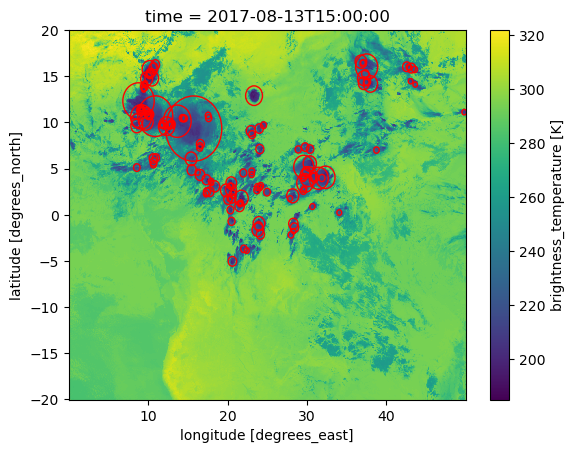

In [198]:
# TESTING event finder 

from matplotlib.patches import Circle  # for a graphical test 

data_array = Tb[20]

centroids,sizes = get_feature_centroids_and_sizes(data_array, sigma=5, threshold=230, min_size=50)
data_array.plot()
for (lat, lon), size in zip(centroids, sizes):
    plt.gca().add_patch(Circle((lon, lat), radius=np.sqrt(size/200/np.pi), fill=False, edgecolor='red'))

np.sum(sizes)

In [195]:
np.sum(sizes)

np.int64(45525)